In [3]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('data/cleaned_chicken_market_study_data.csv', sep=',')
df.head()

,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg)
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,2.850314e+07,6902310.0,56040.0,3.578203e+07
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,5.717738e+07,308122710.0,10870.0,3.743962e+08
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,4.700000e+07,615447940.0,94007430.0,5.131117e+08
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,2.319469e+09,10218320.0,179621830.0,2.193142e+09
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,1.410000e+07,37595230.0,192800.0,5.287238e+07


In [8]:
df.columns

Index(['Country Name', 'Country Code', 'Total Population',
       'Access to Electricity (%)', 'Population Growth Rate',
       'Urban Population Growth Rate', 'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index', 'GDP per Capita Growth (%)',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Import Quantity (kg)', 'Export Quantity (kg)',
       'Poultry Consumption (kg)'],
      dtype='object')

## PCA: Dimensionality Reduction for Market Indicators
We will standardize selected numeric indicators, run PCA to reduce dimensionality, examine explained variance, visualize the 2D projection (PC1 vs PC2), and inspect feature loadings to interpret principal components.

In [ ]:
# Select numeric features for PCA
numeric_cols = [
        # 'Total Population',
        # 'Population Growth Rate', 'Urban Population Growth Rate',
        'Urban Population', 'Political Stability Index',
        'Regulatory Quality Index', 'Logistics Performance Index',
        'GDP per Capita (current US$)', 
        # 'GDP per Capita Growth (%)',
        'Poultry consumption (kg)',
        'Access to Electricity (%)',
        'Chicken Meat Production (kg)', 'Import Quantity (kg)',
        'Export Quantity (kg)'
]

# Keep only columns that actually exist
numeric_cols = [c for c in numeric_cols if c in df.columns]
print('Using features for PCA:', numeric_cols)

# Filter data and drop rows with missing values in these columns
X = df[numeric_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Keep aligned country identifiers for later plots
id_cols = [c for c in ['Country or Area', 'Country Code'] if c in df.columns]
ids = df.loc[X.index, id_cols].copy() if id_cols else None

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Shape after cleaning:', X.shape)

Using features for PCA: ['Urban Population', 'Political Stability Index', 'Regulatory Quality Index', 'Logistics Performance Index', 'GDP per Capita (current US$)', 'Poultry consumption (kg)', 'Access to Electricity (%)', 'Chicken Meat Production (kg)', 'Import Quantity (kg)', 'Export Quantity (kg)']
Shape after cleaning: (104, 10)


In [21]:
X_scaled

array([[-0.24336124, -3.06034803, -1.70065229, ..., -0.36955115,
        -0.51671708, -0.25023552],
       [-0.11609485, -0.75619551, -0.96983055, ..., -0.35944874,
         0.95772155, -0.2503139 ],
       [-0.26208714,  0.89750178,  0.83383046, ..., -0.3630344 ,
         2.46204261, -0.0872081 ],
       ...,
       [-0.1787663 , -0.24024981, -0.90787664, ..., -0.32716858,
        -0.30214934, -0.24973284],
       [ 0.01988244, -0.05349159, -0.77562578, ...,  0.10089239,
         0.7567847 , -0.24573614],
       [ 0.05755195, -0.81789855, -0.50660542, ...,  0.30777634,
         0.87264805, -0.17082223]], shape=(104, 10))

Explained variance ratio per component:
[0.3572 0.3144 0.113  0.0792 0.0475 0.041  0.0268 0.0131 0.0069 0.0009]
Cumulative explained variance:
[0.3572 0.6716 0.7847 0.8639 0.9114 0.9524 0.9792 0.9922 0.9991 1.    ]


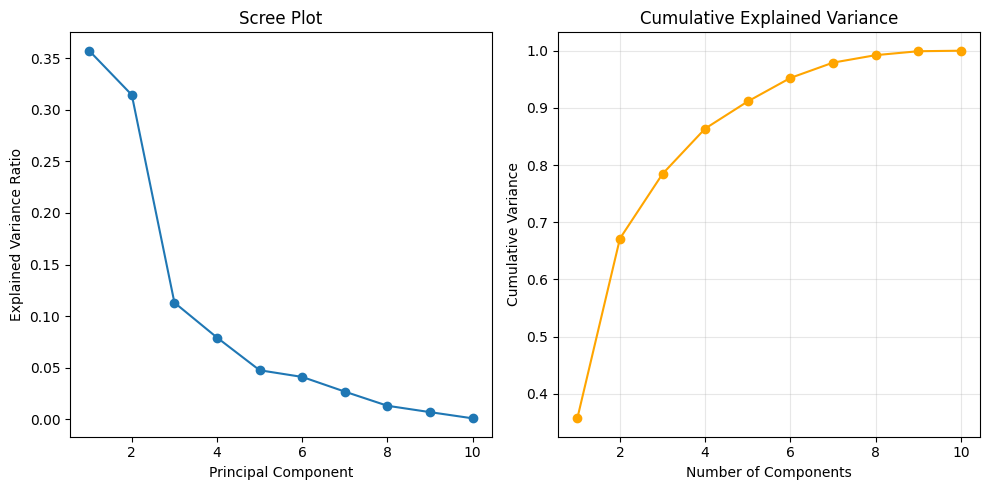

In [22]:
# Fit PCA on standardized data
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
print('Explained variance ratio per component:')
print(np.round(explained_var, 4))
print('Cumulative explained variance:')
print(np.round(np.cumsum(explained_var), 4))

# Scree plot and cumulative variance
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1,2,2)
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), marker='o', color='orange')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
import plotly.express as px
import plotly.graph_objects as go

# Choose number of components (2D for visualization)
pc = 2
pca_2 = PCA(n_components=pc)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Prepare a DataFrame with PCs and identifiers
pc_cols = [f'PC{i+1}' for i in range(pc)]
df_pca = pd.DataFrame(X_pca_2, columns=pc_cols, index=X.index)
if ids is not None:
    df_pca = pd.concat([ids.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)
    
# Create interactive scatter plot
fig = px.scatter(df_pca, 
                x='PC1', 
                y='PC2',
                hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                title='Interactive PCA: Chicken Market Analysis',
                labels={
                    'PC1': 'PC1 - Market Size Factor',
                    'PC2': 'PC2 - Economic Development Factor'
                })

# Customize hover template
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  'Market Size (PC1): %{x:.2f}<br>' +
                  'Economic Development (PC2): %{y:.2f}' +
                  '<extra></extra>',
    hovertext=df_pca['Country Code'] if 'Country Code' in df_pca.columns else df_pca.index
)

# Add quadrant lines for market segmentation
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5)

# Add quadrant labels
fig.add_annotation(x=2, y=2, text="Large & Developed<br>(Premium Markets)", 
                  showarrow=False, bgcolor="lightblue", opacity=0.7)
fig.add_annotation(x=2, y=-2, text="Large & Developing<br>(Volume Markets)", 
                  showarrow=False, bgcolor="lightgreen", opacity=0.7)
fig.add_annotation(x=-2, y=2, text="Small & Developed<br>(Niche Markets)", 
                  showarrow=False, bgcolor="lightyellow", opacity=0.7)
fig.add_annotation(x=-2, y=-2, text="Small & Developing<br>(Emerging Markets)", 
                  showarrow=False, bgcolor="lightcoral", opacity=0.7)

fig.update_layout(width=800, height=600)
fig.show()

Top contributors to PC1:
Poultry consumption (kg)        0.426113
Chicken Meat Production (kg)    0.421048
Logistics Performance Index     0.356038
Urban Population                0.354103
Export Quantity (kg)            0.316142
GDP per Capita (current US$)    0.271512
Regulatory Quality Index        0.267530
Import Quantity (kg)            0.266145
Access to Electricity (%)       0.213600
Political Stability Index       0.165226
Name: PC1, dtype: float64

Top contributors to PC2:
Regulatory Quality Index        0.450669
Political Stability Index       0.427305
GDP per Capita (current US$)    0.379129
Logistics Performance Index     0.326738
Access to Electricity (%)       0.198640
Import Quantity (kg)           -0.131249
Export Quantity (kg)           -0.158042
Chicken Meat Production (kg)   -0.295547
Urban Population               -0.311604
Poultry consumption (kg)       -0.312578
Name: PC2, dtype: float64



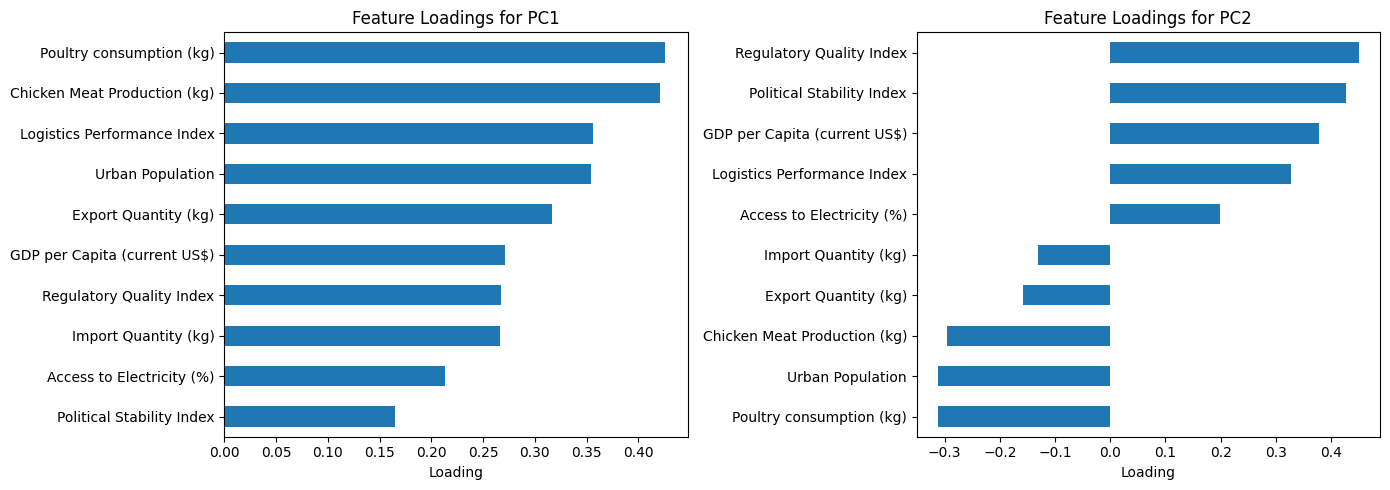

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Urban Population,0.354,-0.312,0.274,0.044,0.336,-0.437,0.086,0.043,0.619,0.066
Political Stability Index,0.165,0.427,-0.013,-0.031,0.733,0.347,-0.204,-0.297,0.021,0.029
Regulatory Quality Index,0.268,0.451,-0.002,-0.100,0.044,0.021,0.161,0.829,-0.007,-0.001
Logistics Performance Index,0.356,0.327,0.109,-0.165,-0.200,-0.118,0.687,-0.434,-0.114,-0.020
GDP per Capita (current US$),0.272,0.379,-0.048,-0.240,-0.355,-0.396,-0.635,-0.170,0.086,0.012
Poultry consumption (kg),0.426,-0.313,0.037,0.001,0.162,-0.109,-0.122,0.045,-0.501,-0.643
Access to Electricity (%),0.214,0.199,-0.016,0.940,-0.162,0.013,-0.047,-0.046,0.027,-0.012
Chicken Meat Production (kg),0.421,-0.296,-0.259,-0.010,0.052,0.001,-0.047,0.027,-0.374,0.723
Import Quantity (kg),0.266,-0.131,0.665,-0.089,-0.296,0.578,-0.167,0.011,0.077,0.077
Export Quantity (kg),0.316,-0.158,-0.633,-0.104,-0.196,0.414,0.045,-0.036,0.446,-0.228


In [24]:
# Feature loadings (contribution of each original feature to PCs)
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))]
)

# Show top contributing features for PC1 and PC2
for i in range(2):
    pc_name = f'PC{i+1}'
    print(f"Top contributors to {pc_name}:")
    print(loadings[pc_name].sort_values(ascending=False).head(10))
    print()

# Visualize loadings for PC1 & PC2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, ax in enumerate(axes[:2]):
    pc_name = f'PC{i+1}'
    loading_sorted = loadings[pc_name].sort_values()
    loading_sorted.plot(kind='barh', ax=ax)
    ax.set_title(f'Feature Loadings for {pc_name}')
    ax.set_xlabel('Loading')
plt.tight_layout()
plt.show()

loadings.round(3)

### Plot features on PCA (Biplot + Correlation Circle)
We overlay feature loadings as arrows on the PC1–PC2 scores (biplot) and show a correlation circle to interpret contributions.

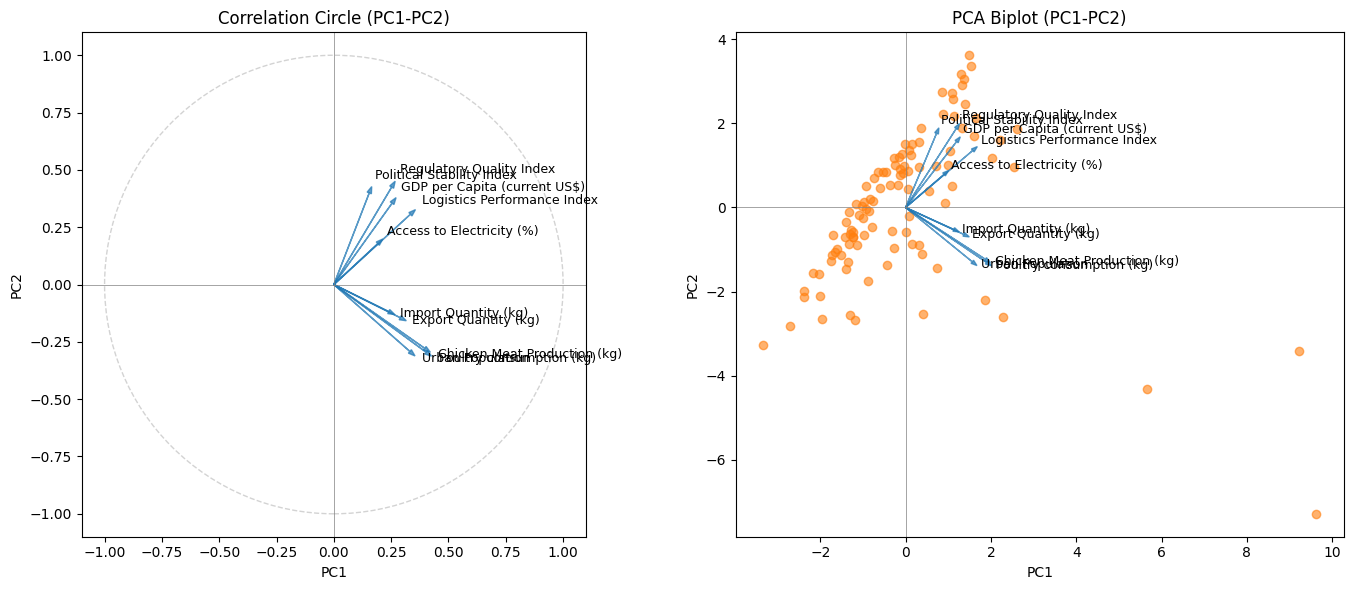

In [25]:
# Biplot: PC scores with feature loadings as arrows
# Use the PCA already fitted into `pca` (full), `numeric_cols`, `X_scaled`, and `df_pca` with PC1/PC2

# 1) Correlation circle (unit circle) and feature vectors on PC1-PC2
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# Left: correlation circle
ax0 = ax[0]
circle = plt.Circle((0,0), 1, color='lightgrey', fill=False, linestyle='--')
ax0.add_artist(circle)

# Project loadings of first two PCs
loadings_2d = pca.components_.T[:, :2]
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0], loadings_2d[i, 1]
    ax0.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.02, length_includes_head=True)
    ax0.text(x*1.08, y*1.08, feature, fontsize=9)

ax0.set_title('Correlation Circle (PC1-PC2)')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.axhline(0, color='grey', linewidth=0.5)
ax0.axvline(0, color='grey', linewidth=0.5)
ax0.set_aspect('equal', 'box')
ax0.set_xlim(-1.1, 1.1)
ax0.set_ylim(-1.1, 1.1)

# Right: biplot (scores + scaled loadings)
ax1 = ax[1]
ax1.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.6, color='tab:orange')

# Scale loading vectors to score space for visibility
scores_std = np.std(df_pca[['PC1','PC2']], axis=0).values
load_scale = 2.5 * scores_std  # tweak factor for readability
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0]*load_scale[0], loadings_2d[i, 1]*load_scale[1]
    ax1.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.02*load_scale[0], length_includes_head=True)
    ax1.text(x*1.05, y*1.05, feature, fontsize=9)

ax1.set_title('PCA Biplot (PC1-PC2)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.axhline(0, color='grey', linewidth=0.5)
ax1.axvline(0, color='grey', linewidth=0.5)
plt.tight_layout()
plt.show()

base on the attributes that related to PC1 such as import, export, consumption, production, and urbanization population, we can consider this as Market size factor. Whereas PC2 related more to the reulatory, political, gdp, logistic, and access to electricity, we can considered them as Economic development factor.

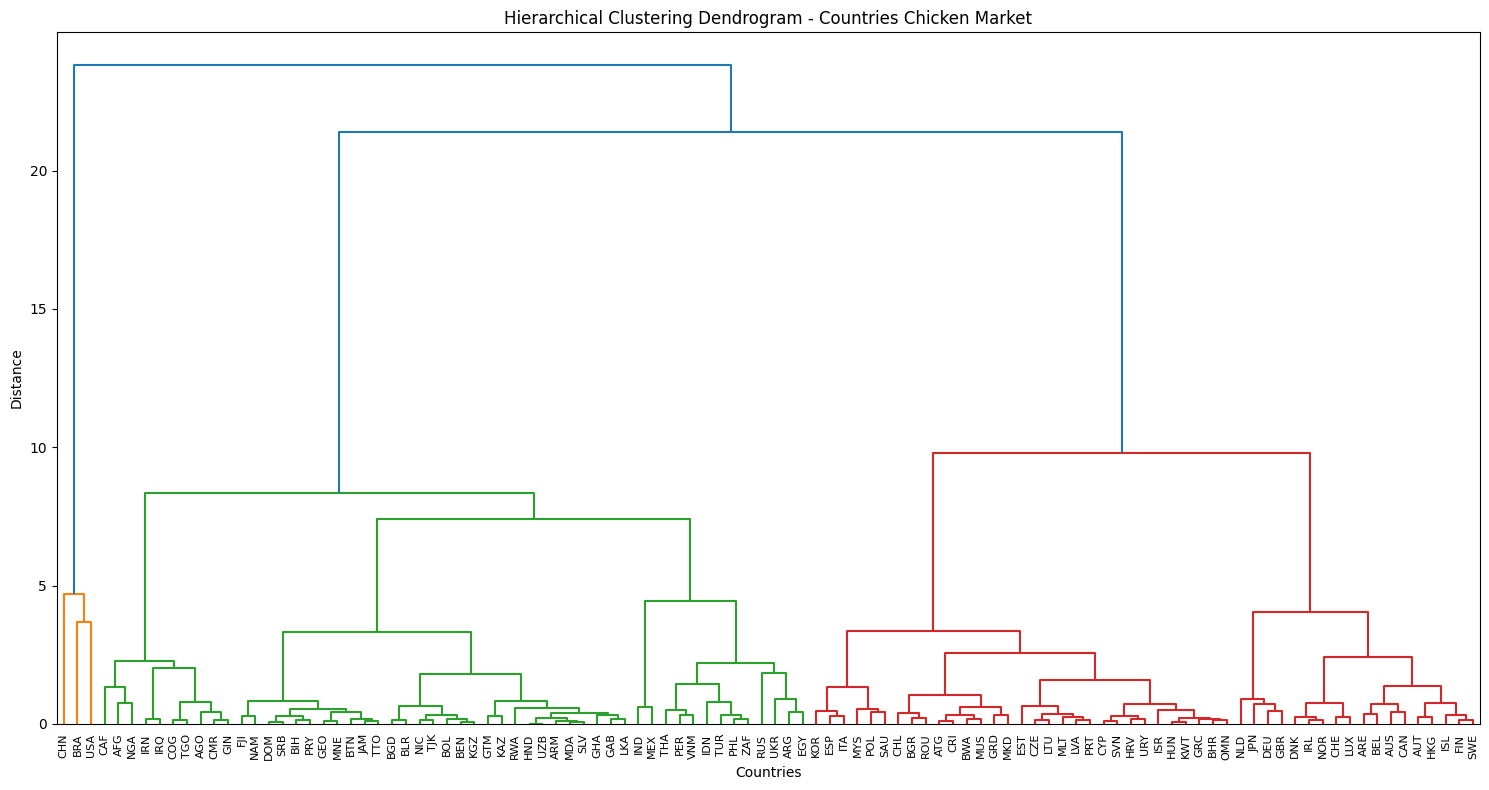

Dendrogram shows how countries are grouped based on market characteristics
Look for natural breaks in the tree to determine optimal number of clusters


In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use PCA coordinates for clustering (PC1 and PC2)
X_for_clustering = df_pca[['PC1', 'PC2']].values

# Create linkage matrix using Ward method
linkage_matrix = linkage(X_for_clustering, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendro = dendrogram(linkage_matrix, 
                   labels=df_pca['Country Code'].values if 'Country Code' in df_pca.columns else None,
                   leaf_rotation=90,
                   leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram - Countries Chicken Market')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

print("Dendrogram shows how countries are grouped based on market characteristics")
print("Look for natural breaks in the tree to determine optimal number of clusters")

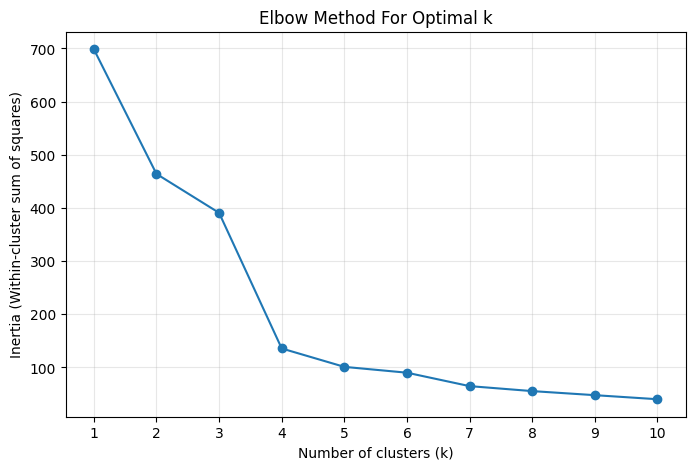

In [27]:
inertia = []
K_range = range(1, 11)
X_for_clustering = df_pca[['PC1', 'PC2']].values

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.show()

In [38]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# 3. Visualize clusters
fig = px.scatter(df_pca, x='PC1', y='PC2', color='Cluster', 
                 hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                 title='K-means Clusters on PCA')
fig.show()

In [45]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# 3. Visualize clusters
fig = px.scatter(df_pca, x='PC1', y='PC2', color='Cluster', 
                 hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                 title='K-means Clusters on PCA')
fig.show()

In [46]:
for k in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_for_clustering)
    score = silhouette_score(X_for_clustering, labels)
    print(f"Silhouette score for k={k}: {score:.3f}")

Silhouette score for k=3: 0.342
Silhouette score for k=4: 0.402
Silhouette score for k=5: 0.447
Silhouette score for k=6: 0.436


In [47]:
df_pca

,Country Code,PC1,PC2,Cluster
0,AFG,-2.697722,-2.817180,1
1,AGO,-2.002866,-2.105004,1
2,ARE,1.604770,1.705431,0
3,ARG,-0.279899,-0.952172,2
4,ARM,-1.305226,-0.627519,1
...,...,...,...,...
99,URY,-0.282154,1.183159,2
100,USA,9.216515,-3.402627,3
101,UZB,-1.220433,-0.699795,1
102,VNM,0.008788,-0.581961,2
